<a href="https://colab.research.google.com/github/Daniellien2018/Project_7_Twitter_US_Airline_Sentiment/blob/main/Daniel_Lien_NLP_Full_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Natural Language Processing: Twitter US Airline Sentiment

## Problem Statement

### Context

Twitter's massive user base of 330 million monthly active users presents a direct avenue for businesses to connect with a broad audience. However, the vast amount of information on the platform makes it challenging for brands to swiftly detect negative social mentions that may impact their reputation. To tackle this, sentiment analysis has become a crucial tool in social media marketing, enabling businesses to monitor emotions in conversations, understand customer sentiments, and gain insights to stay ahead in their industry.

That's why sentiment analysis/classification, which involves monitoring emotions in conversations on social media platforms, has become a key strategy in social media marketing.

### Objective

The aim of this project is to build a sentimental analysis model that classify the sentiment of tweets into the positive, neutral & negative.

### Data Dictionary

* tweet_id - A unique identifier for each tweet                                                          
* airline_sentiment - The sentiment label of the tweet, such as positive, negative, or neutral                                               
* airline_sentiment_confidence - The confidence level associated with the sentiment label                               
* negativereason - A category indicating the reason for negative sentiment                                                   
* negativereason_confidence - The confidence level associated with the negative reason                                    
*airline - The airline associated with the tweet                                                                   
* airline_sentiment_gold - Gold standard sentiment label                                               
* name - The username of the tweet author    
* retweet_count - The number of times the tweet has been retweeted
* text - The actual text content of the tweet.
* tweet_coord - Coordinates of the tweet
* tweet_created - The timestamp when the tweet was created
* tweet_location - The location mentioned in the tweet
* user_timezone - The timezone of the tweet author

## Importing necessary libraries

In [2]:
# install and import necessary libraries.

!pip install contractions
# For TensorFlow/Keras
!pip install tensorflow
# For NLTK
!pip install nltk

import re, string, unicodedata
import contractions
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('omw-1.4')

from tensorflow.keras import backend
import random
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Dropout

# from nltk.tokenize import Tokenizer, pad_sequnces
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Loading the dataset

In [3]:
# Mount Google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#read the data
path = '/content/drive/My Drive/UT Austin AIML/Datasets/Tweets.csv'
data = pd.read_csv(path)

## Data Overview

The initial steps to get an overview of any dataset is to:
- Observe the first few rows of the dataset, to check whether the dataset has been loaded properly or not
- Get information about the number of rows and columns in the dataset
- Find out the data types of the columns to ensure that data is stored in the preferred format and the value of each property is as expected.

In [5]:
#get the head of dataset
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
#get tail of dataset
data.tail()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)
14639,569587140490866689,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know h...,NaN,2015-02-22 11:58:51 -0800,"dallas, TX",NaN


In [7]:
#check shape of data
data.shape

(14640, 15)

In [8]:
#check datatypes of data
data.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

In [9]:
#check for missing values
data.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [10]:
#check for unique data.
data.nunique()

tweet_id                        14485
airline_sentiment                   3
airline_sentiment_confidence     1023
negativereason                     10
negativereason_confidence        1410
airline                             6
airline_sentiment_gold              3
name                             7701
negativereason_gold                13
retweet_count                      18
text                            14427
tweet_coord                       832
tweet_created                   14247
tweet_location                   3081
user_timezone                      85
dtype: int64

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Questions**:

- What is the percentage of tweets for each airline?
- What is the distribution of sentiments across all the tweets?
- What is the distribution of sentiments for each airline?
- What does the plot of negative reasons indicate?
- How does a wordcloud appear for negative tweets?
- How does a wordcloud appear for positive tweets?
- What are insights observed from EDA?

### Univariate Analysis

In [11]:
#functions for univariate analysis
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

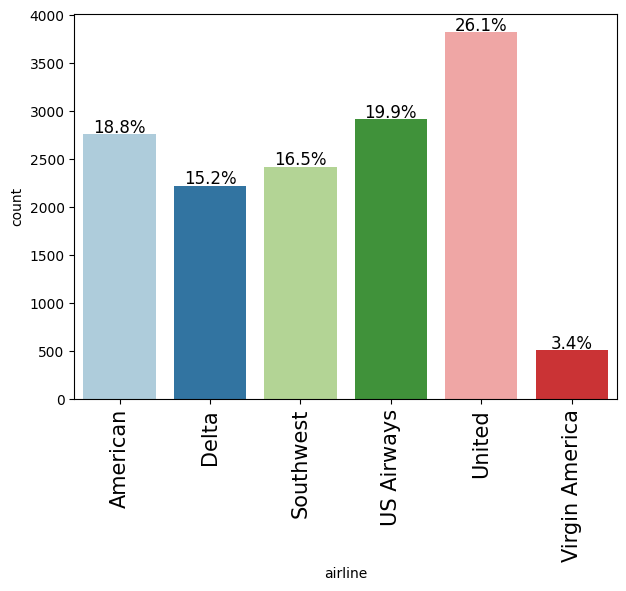

In [12]:
#percentage of tweets per airline
labeled_barplot(data, "airline", perc=True)



*   United Airlines had the most percentage of tweets, while Virgin American had the least. Non-significant since it can be reasoned that United has the largest customer base.





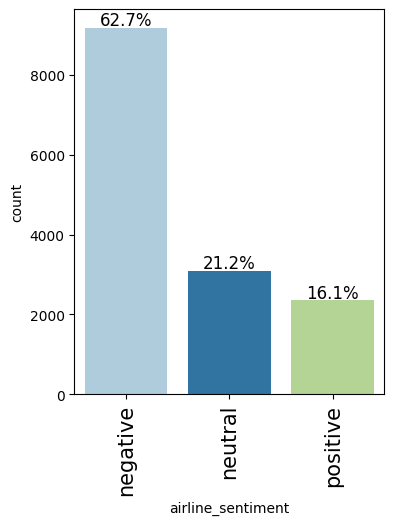

In [13]:
#distribution of sentiments across all airlines
labeled_barplot(data, "airline_sentiment", perc=True)



*   A large majority of reviews are negative, regardless of airline.


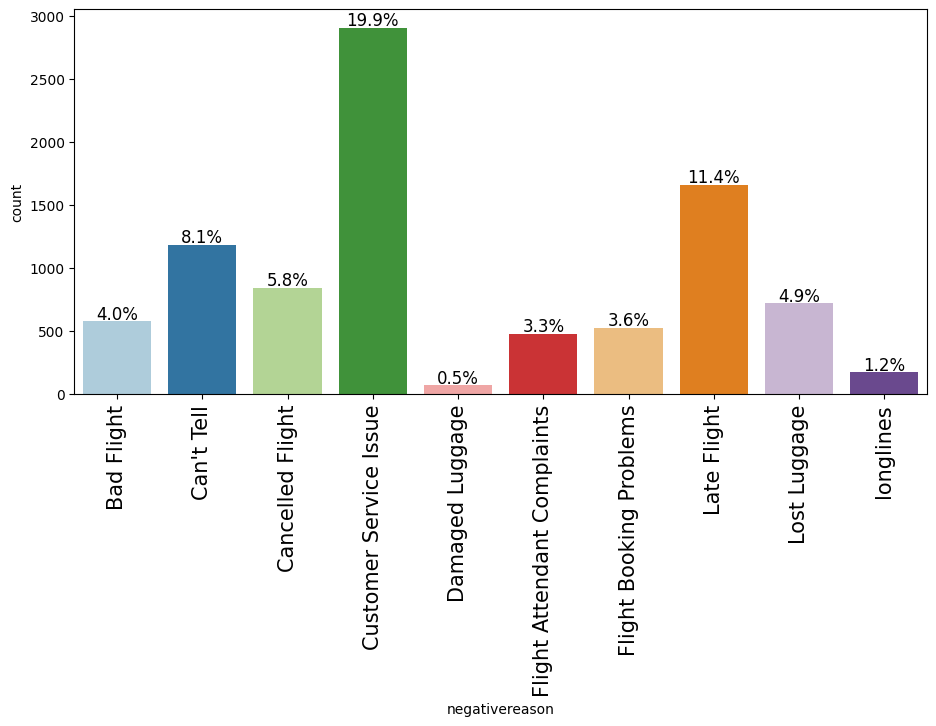

In [14]:
#distribution of all negative reasons
labeled_barplot(data, "negativereason", perc=True)



*   Reasons for negative reviews are relatively distributed, but Customer Service Issues are the most common.



### Bivariate Analysis

<Axes: xlabel='airline'>

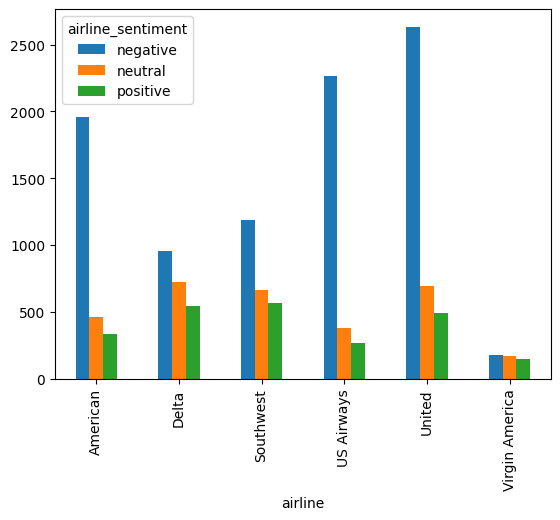

In [15]:
airline_sentiment =  data.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar')



*   Airlines like United and American have the most amount of negative reviews
*   The larget the airline, the more likely it is to have a larger percentage of negative reviews.



### Wordcloud for Negative Reviews

In [16]:
#parse data for only the 'negative' reviews
airline_tweets=data[data['airline_sentiment']=='negative']
#join all words into one large text
words = ' '.join(data['text'])
#split each word on default white space, iterate each word in words
#if logic is used to remove all non-words (ex http, emails)
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'])

In [17]:
#create a word cloud using stopwords
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

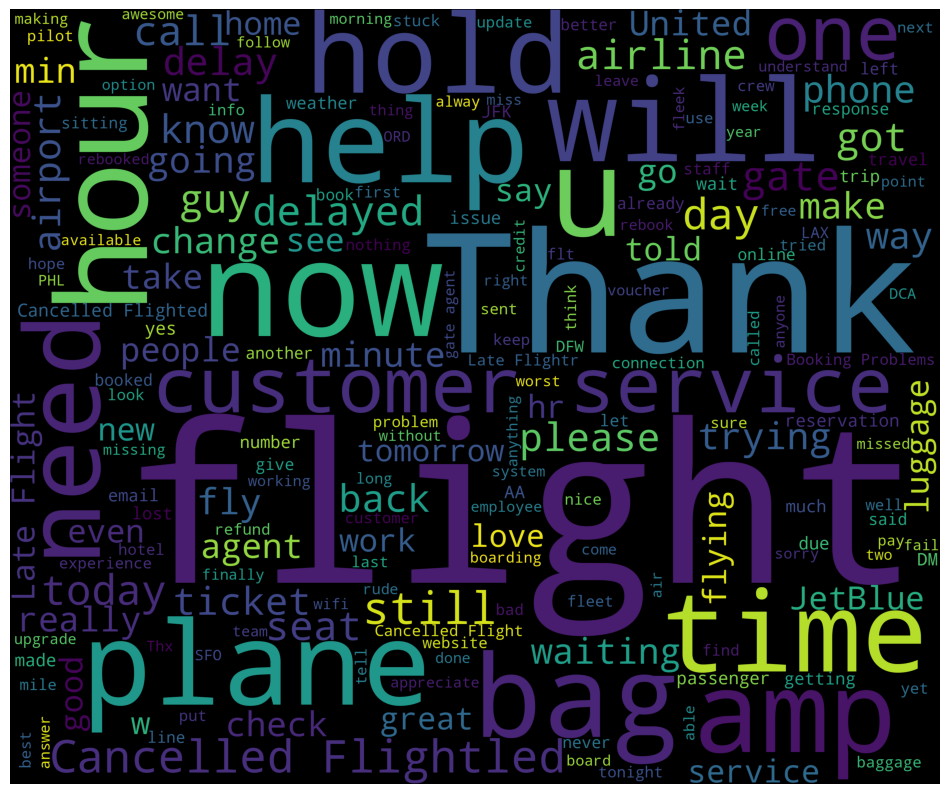

In [18]:
#set size and plot
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Wordcloud for Positive reviews

In [19]:
#parse data for only the 'positive' reviews
airline_tweets=data[data['airline_sentiment']=='positive']
#join all words into one large text
words = ' '.join(data['text'])
#split each word on default white space, iterate each word in words
#if logic is used to remove all non-words (ex http, emails)
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'])

In [20]:
#create a word cloud using stopwords
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

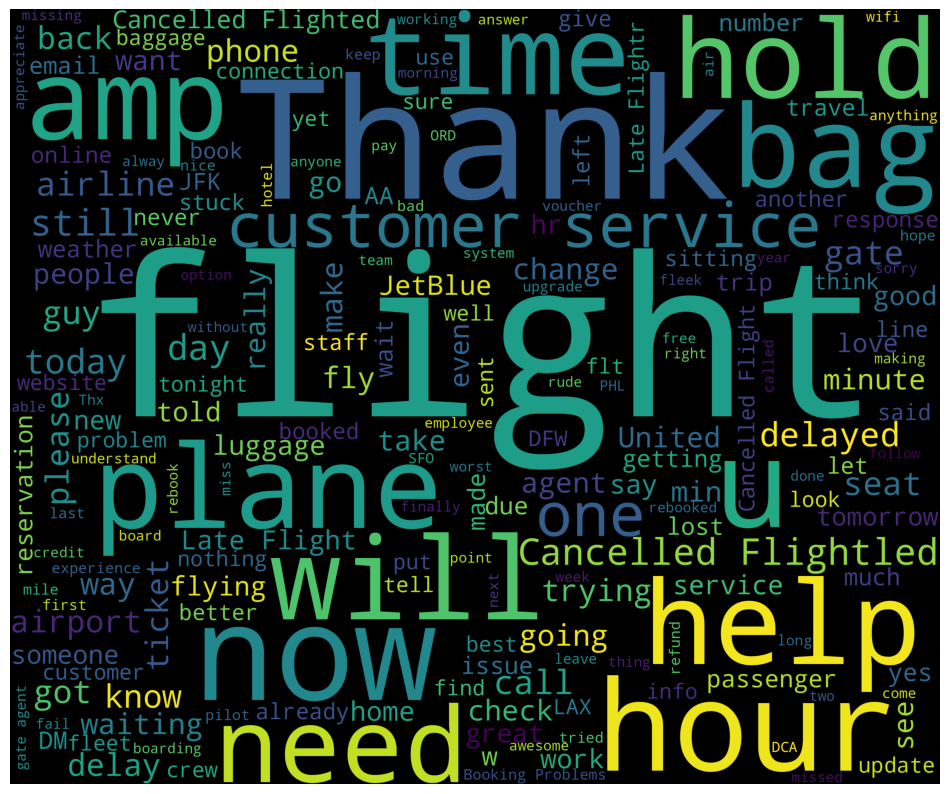

In [21]:
#set size and plot
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Questions


1.   The percentage of tweets for each airline are: American 18%, Delta 15.3%, Southwest 16.7%, US Airways 20.1%, United 26.4%, Virgin America 3.5%
2.   The distribution of sentiments accross all airlines is that a majority of tweets are negative (62.7%), and the minority of tweets are positive (16.1%)
3. The distribution of sentiments for each airline are similar to the distrbitution of all airlines combined. A majority of tweets are negative. Virgin American however has a small variance between positive and negative tweets. While larger airlines like United and US Airways have a high percentage of negative reviews.
4. The plot of negative reasons indicate that the most common reason for a negative review are 'customer service issues'
5. The wordcloud for negative reviews emphasizes words like "flight". Some strong indicators are "late" "customer serivce', and 'bag'
6. The wordcloud of positive reviews emphasizes words like 'helpful', and 'on-time'
7. Some insights from EDA include that the majority of reviews are negative. This suggest that customers typically only write reviews upon having bad experiences. The more reviews a company has, the more likely it is to have a higher percentage of bad reviews.




## Data Preparation for Modeling

- Drop all unnecessary columns
- Remove html tags
- Replace contractions in string(e.g. replace I'm --> I am) and so on.\
- Remove numbers
- Tokenization
- To remove Stopwords
- Lemmatized data

### Drop all unnecessary columns

In [22]:
# Take text and airline sentiment columns from the data

#all we are trying to do is categorize each text into pos, neg, or neutral
#for that we only need 'text', 'airline_sentiment', all else is fluff

data = data[['text', 'airline_sentiment']]

In [23]:
#check our data
data.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [24]:
#check our data
data.shape

(14640, 2)

In [25]:
#check for unique values in 'airline sentiment' should only have 3(pos, neg, neutral)
data['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [26]:
#check the values in 'airline_sentiment' column
data['airline_sentiment'].values

array(['neutral', 'positive', 'neutral', ..., 'neutral', 'negative',
       'neutral'], dtype=object)

### Remove HTML tags

In [27]:
#remove html tags using beautiful soup package
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

data['text'] = data['text'].apply(strip_html)
data.head()

<ipython-input-27-0318c33dbdb6>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


### Replace concatenations in string

In [28]:
#replace concatenations
def replace_contractions(text):
    return contractions.fix(text)

#apply function
data['text'] = data['text'].apply(lambda x: replace_contractions(x))
data.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you have added commercials...,positive
2,@VirginAmerica I did not today... Must mean I ...,neutral
3,@VirginAmerica it is really aggressive to blas...,negative
4,@VirginAmerica and it is a really big bad thin...,negative


### Remove Numbers

In [29]:
#remove numbers
def remove_numbers(text):
  #re.sub syntax
  #re.sub(r'\removed, replaced, text)
  #d+ for all digits
  text = re.sub(r"\b\d+\b", '', text)
  return text

data['text'] = data['text'].apply(remove_numbers)
data.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you have added commercials...,positive
2,@VirginAmerica I did not today... Must mean I ...,neutral
3,@VirginAmerica it is really aggressive to blas...,negative
4,@VirginAmerica and it is a really big bad thin...,negative


### Apply Tokenization

In [30]:
#apply tokenization using nltk
data.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)

0           [@, VirginAmerica, What, @, dhepburn, said, .]
1        [@, VirginAmerica, plus, you, have, added, com...
2        [@, VirginAmerica, I, did, not, today, ..., Mu...
3        [@, VirginAmerica, it, is, really, aggressive,...
4        [@, VirginAmerica, and, it, is, a, really, big...
                               ...                        
14635    [@, AmericanAir, thank, you, we, got, on, a, d...
14636    [@, AmericanAir, leaving, over, minutes, Late,...
14637    [@, AmericanAir, Please, bring, American, Airl...
14638    [@, AmericanAir, you, have, my, money, ,, you,...
14639    [@, AmericanAir, we, have, people, so, we, nee...
Length: 14640, dtype: object

In [31]:
# apply tokenization on text column
data['text'] = data.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)

data.head()

,text,airline_sentiment
0,"[@, VirginAmerica, What, @, dhepburn, said, .]",neutral
1,"[@, VirginAmerica, plus, you, have, added, com...",positive
2,"[@, VirginAmerica, I, did, not, today, ..., Mu...",neutral
3,"[@, VirginAmerica, it, is, really, aggressive,...",negative
4,"[@, VirginAmerica, and, it, is, a, really, big...",negative


### Applying lowercase, removing stopwords and punctuation

In [32]:
#use stopwords dict
stopwords = stopwords.words('english')

customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.
# We want to keep these custom words, do not add them to list of stopwords
stopwords = list(set(stopwords) - set(customlist))

In [33]:
#Group words using WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

#simply loop for each preprocessing step.
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

#normalize fnc will call all the methods we just created
def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

data['text'] = data.apply(lambda row: normalize(row['text']), axis=1)
data.head()

,text,airline_sentiment
0,virginamerica dhepburn say,neutral
1,virginamerica plus add commercials experience ...,positive
2,virginamerica not today must mean need take an...,neutral
3,virginamerica really aggressive blast obnoxiou...,negative
4,virginamerica really big bad thing,negative




*   Preprocessing complete, we are now ready to build our models



## Model Building

### Using countvectorizer

- Intialize countvectorizer and use it for vectorization
- Store Independent and Dependent variables
- Split the data into train and test
- Build a Random Forest model on train data
- Use Cross validation to validate the score and to find optimal n_estimators
- Plot the misclassification error for each of estimators
- Test the model on testing data
- Plot the Confusion matrix
plot word cloud for top 20 important features obtained from Count vectorizer and random forest model


In [34]:
#use scikit countvectorizer, fit_transform on text column
countvector = CountVectorizer(max_features=5000)
data_features = countvector.fit_transform(data['text'])

#convert into array
data_features = data_features.toarray()


In [35]:
#check shape
data_features.shape

(14640, 5000)

In [36]:
#Create independent and dependent variables
X = data_features
y = data['airline_sentiment']

In [37]:
#split data into training and testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

In [38]:
#Random Forest Model

#initiate RFC
forest = RandomForestClassifier(n_estimators=100, n_jobs=4)

#fit forest on train data
forest = forest.fit(X_train, y_train)

#print, calculate cross validatino score
print(forest)
print(np.mean(cross_val_score(forest, X, y, cv=10)))

RandomForestClassifier(n_jobs=4)
0.7359972677595629


In [39]:
#Optimize the Parameters with K-fold cross validation
#repeat RFC for k

#create an array with [1-24] using list comprehension
base_ln = [x for x in range(1, 25)]

# K-Fold Cross - validation, rfc for each base_ln
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X, y, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())
print(cv_scores)

[0.5992486338797814, 0.6593579234972677, 0.6690573770491803, 0.6960382513661202, 0.6935109289617486, 0.6916666666666667, 0.6881147540983606, 0.6946721311475409, 0.7030054644808743, 0.6953551912568307, 0.6942622950819672, 0.7029371584699453, 0.7034836065573771, 0.698155737704918, 0.7040983606557377, 0.6989754098360657, 0.7056693989071038, 0.7068989071038251, 0.7057377049180328, 0.7077868852459017, 0.7058060109289617, 0.70724043715847, 0.707035519125683, 0.7026639344262295]


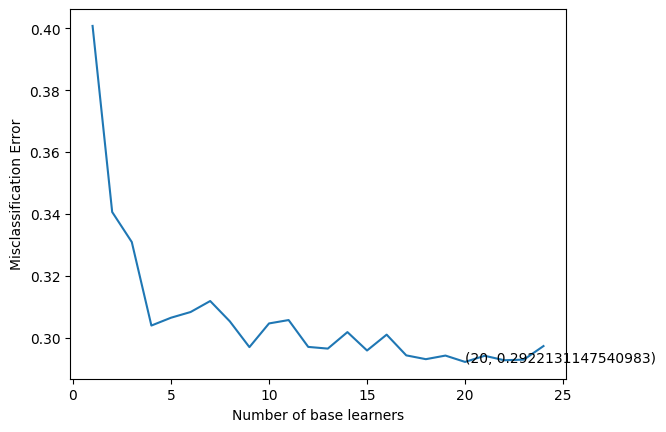

In [40]:
# plot the error as k increases
# Error corresponds to each number of estimator
error = [1 - x for x in cv_scores]
# Selection of optimal number of n_estimator corresponds to minimum error.
optimal_learners = base_ln[error.index(min(error))]
# Plot between each number of estimator and misclassification error
plt.plot(base_ln, error)
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [41]:
# Train the best model and calculating accuracy on test data .
# Initialize the Random Forest classifier using min from plot
clf = RandomForestClassifier(n_estimators = 20)
 # Fit the classifer on X_train and y_train
clf.fit(X_train, y_train)
# Find the score on X_train and y_train
clf.score(X_train,y_train)


0.9910348360655737

In [42]:
# Predict the result for test data using the model built above.
result = clf.predict(X_test)

# Print and plot Confusion matirx
conf_mat = confusion_matrix(y_test, result)

print(conf_mat)


[[1723  131   35]
 [ 251  283   46]
 [ 115   63  281]]


<Axes: >

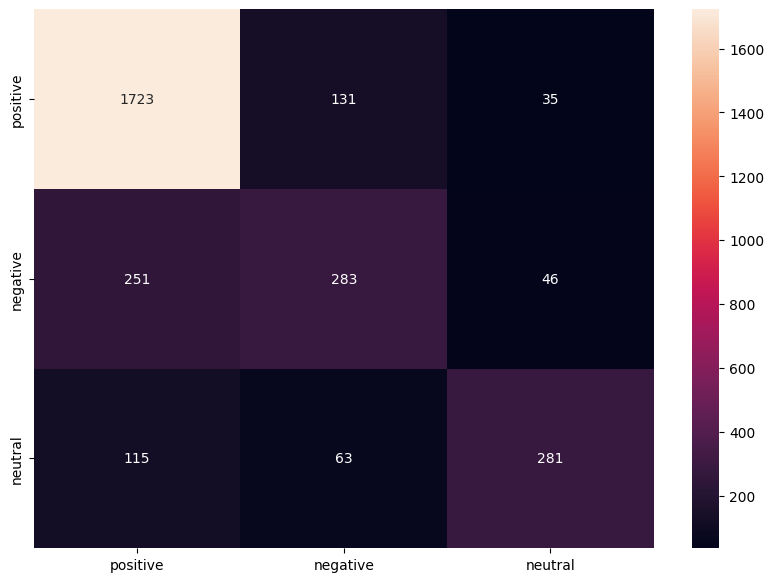

In [43]:
# Plot the confusion matrix, heatmap
df_cm = pd.DataFrame(conf_mat, index = [i for i in ['positive', 'negative', 'neutral']],
                  columns = [i for i in ['positive', 'negative', 'neutral']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In [44]:
#create wordcloud of top 20 features from countevec + randomforest
#get features names
all_features = countvector.get_feature_names_out()
top_features=''
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:20]:
    top_features+=all_features[i]
    top_features+=','

print(top_features)

print(" ")
print(" ")

# applying wordcloud on top features
wordcloud = WordCloud(background_color="white",colormap='viridis',width=200).generate(top_features)


thank,not,jetblue,great,delay,flight,usairways,southwestair,hold,love,unite,http,awesome,hours,cancel,get,americanair,virginamerica,bag,wait,
 
 


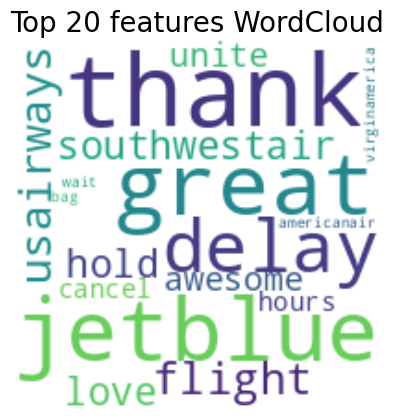

In [45]:
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 20 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

### Using TF-IDF (Term Frequency- Inverse Document Frequency)

- Intialize TFIDF and use it for vectorization
- Store Independent and Dependent variables
- Split the data into train and test
- Build a Random Forest model on train data
- Use Cross validation to validate the score and to find optimal n_estimators
- Plot the misclassification error for each of estimators
- Test the model on testing data
- Plot the Confusion matrix
plot word cloud for top 20 important features obtained from TFIDF and random forest model


In [46]:
#initialize tfidf vector and fit_transform on text data
tfidf_vect = TfidfVectorizer(max_features=500)
data_features = tfidf_vect.fit_transform(data['text'])

#convert to array
data_features = data_features.toarray()
#check
data_features.shape

(14640, 500)

In [47]:
#create indepndent and dependent, split into train and test set

X = data_features
y = data['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
#random forest model

#Initiate RFC and fit on train data
forest = RandomForestClassifier(n_estimators=100, n_jobs=4)
forest = forest.fit(X_train, y_train)

print(forest)
#calcualte cross val score on forest
print(np.mean(cross_val_score(forest, X, y, cv=10)))

RandomForestClassifier(n_jobs=4)
0.7234972677595628


In [49]:
#Optimize Parameters

# Finding optimal number of base learners using k-fold CV ->
base_ln = [x for x in range(1, 25)]

# K-Fold Cross - validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X, y, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())
print(cv_scores)

[0.6136612021857923, 0.6537568306010929, 0.6659836065573771, 0.6728142076502732, 0.6793032786885246, 0.6680327868852458, 0.6765710382513661, 0.6738387978142077, 0.6816256830601093, 0.6845628415300545, 0.6849043715846996, 0.6780054644808743, 0.6843579234972677, 0.680396174863388, 0.683811475409836, 0.6833333333333333, 0.6889344262295082, 0.6831967213114754, 0.6890710382513661, 0.6879781420765027, 0.6829234972677596, 0.6927595628415301, 0.6834699453551913, 0.6869535519125682]


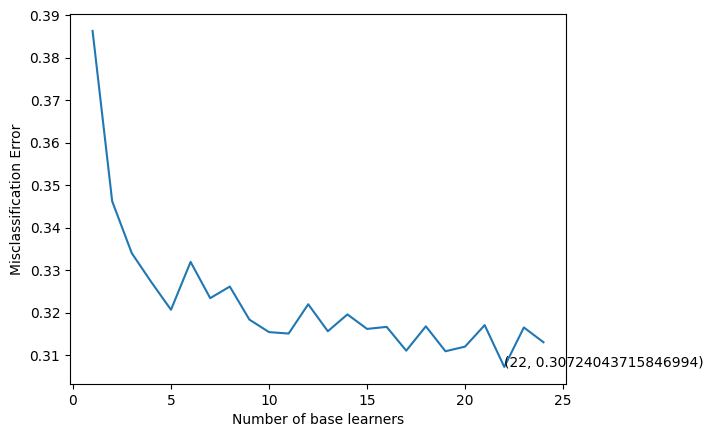

In [50]:
# plot the error as k increases
# Error corresponds to each number of estimator
error = [1 - x for x in cv_scores]
# Selection of optimal number of n_estimator corresponds to minimum error.
optimal_learners = base_ln[error.index(min(error))]
# Plot between each number of estimator and misclassification error
plt.plot(base_ln, error)
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [51]:
# Train the best model and calculating accuracy on test data .
clf = RandomForestClassifier(n_estimators = 17)
#fit the classifier adn find the score
clf.fit(X_train,y_train)
clf.score(X_train,y_train)

0.9770321038251366

In [52]:
# Predict the result for test data using the model built above.
result = clf.predict(X_test)

# Plot Confusion matirx
conf_mat = confusion_matrix(y_test, result)

<Axes: >

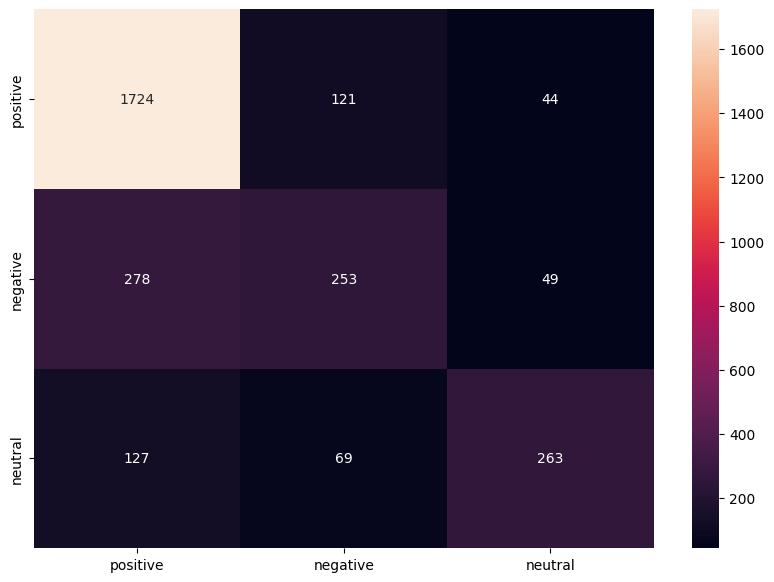

In [53]:
#plot the confusion matrix
df_cm = pd.DataFrame(conf_mat, index = [i for i in ['positive', 'negative', 'neutral']],columns = [i for i in ['positive', 'negative', 'neutral']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In [54]:
#create wordcloud of top 40 features from countevec + randomforest
#get features names
all_features = tfidf_vect.get_feature_names_out()
top_features=''
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:20]:
    top_features+=all_features[i]
    top_features+=','

print(top_features)

print(" ")
print(" ")

# applying wordcloud on top features
wordcloud = WordCloud(background_color="white",colormap='viridis',width=200).generate(top_features)

thank,not,jetblue,southwestair,http,americanair,unite,great,usairways,delay,flight,virginamerica,love,get,awesome,hours,cancel,hold,please,fly,
 
 


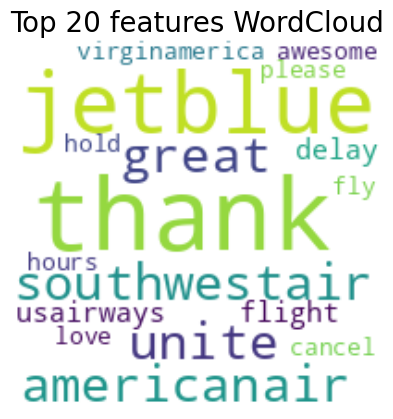

In [55]:
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 20 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

### Using LSTM

- Tokenize the text column
- Encode the target variable
- Split the data into train and test
- Train the LSTM model
- Test the model on train and test data
- Plot the confusion matrix

In [56]:
# Clearing backend
backend.clear_session()
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [57]:
#Tokenizing the Text Column

tokenizer = Tokenizer(num_words = 800, split = ' ')

# Complete the code to fit tokenizer on text data
tokenizer.fit_on_texts(data['text'].values)

# Converting text to sequences
X = tokenizer.texts_to_sequences(data['text'].values)

# Padding the sequences
X = pad_sequences(X)

In [58]:
#Encoding Target Variable
enc = LabelBinarizer()
# Fitting the Label Binarizer on airline_sentiment
y_encoded = enc.fit_transform(data['airline_sentiment'])


In [59]:
#split data into train and test

X_train, X_test, y_train, y_test = train_test_split(X,y_encoded, test_size=0.30, random_state=42)

In [60]:
# Initializing the model
model = Sequential()

# Adding the embedding layer with 800 vocabularies, 120 neurons
model.add(Embedding(800, 120, input_length = X.shape[1]))

# Add the LSTM layer with 256 neurons
model.add(LSTM(256,return_sequences=True))

# Add the LSTM layer with 150 neurons and dropout_rate= 0.2
model.add(LSTM(150, dropout = 0.2, recurrent_dropout = 0.2))

# Add the dense layer with 124 neurons and relu activation function
model.add(Dense(124,activation = 'relu'))

# Add dropout with dropout_rate= 0.2
model.add(Dropout(0.2))

# Add a dense layer with 64 neurons and relu activation function
model.add(Dense(64,activation = 'relu'))

# Add the output layer with 3 neurons and softmax activation function
model.add(Dense(3, activation = 'softmax'))

# Compile the model with categorical_crossentropy as loss function, accuracy as metrics and adam as optimizer
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [61]:
# Summary of the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 120)           96000     
                                                                 
 lstm (LSTM)                 (None, 21, 256)           386048    
                                                                 
 lstm_1 (LSTM)               (None, 150)               244200    
                                                                 
 dense (Dense)               (None, 124)               18724     
                                                                 
 dropout (Dropout)           (None, 124)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8000      
                                                                 
 dense_2 (Dense)             (None, 3)                 1

In [62]:
%%time
#fit the model on X_train and y_train with epochs as 30, batch size as 32
his = model.fit(X_train, y_train, epochs = 30, batch_size = 32, verbose = 'auto')

Epoch 1/30
321/321 [==============================] - 72s 205ms/step - loss: 0.6967 - accuracy: 0.7077
Epoch 2/30
321/321 [==============================] - 64s 198ms/step - loss: 0.5220 - accuracy: 0.7899
Epoch 3/30
321/321 [==============================] - 65s 202ms/step - loss: 0.4847 - accuracy: 0.8068
Epoch 4/30
321/321 [==============================] - 68s 213ms/step - loss: 0.4672 - accuracy: 0.8122
Epoch 5/30
321/321 [==============================] - 62s 193ms/step - loss: 0.4407 - accuracy: 0.8271
Epoch 6/30
321/321 [==============================] - 69s 215ms/step - loss: 0.4195 - accuracy: 0.8391
Epoch 7/30
321/321 [==============================] - 63s 196ms/step - loss: 0.3978 - accuracy: 0.8454
Epoch 8/30
321/321 [==============================] - 64s 198ms/step - loss: 0.3686 - accuracy: 0.8579
Epoch 9/30
321/321 [==============================] - 67s 208ms/step - loss: 0.3418 - accuracy: 0.8656
Epoch 10/30
321/321 [==============================] - 64s 198ms/step - l

In [63]:
# Predicting on X_test using the above model
result = model.predict(X_test)

138/138 [==============================] - 6s 38ms/step


In [64]:
model.evaluate(X_test,y_test)

138/138 [==============================] - 6s 38ms/step - loss: 1.7009 - accuracy: 0.7552


[1.7009297609329224, 0.755236804485321]

In [65]:
# Applying argmax function on the predicted values (result) to get the predicted labels
y_pred_arg=np.argmax(result,axis=1)
# Applying argmax function on the y_test to get back the predicted labels
y_test_arg=np.argmax(y_test,axis=1)

<Axes: >

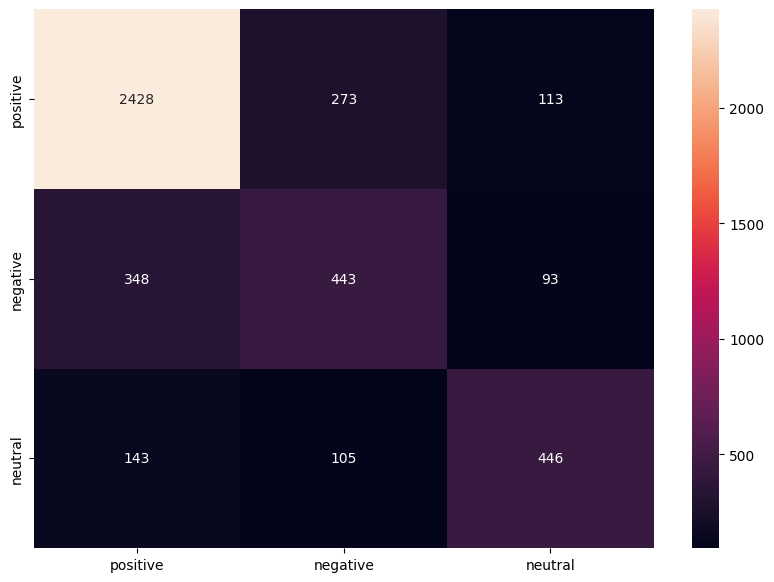

In [66]:
#plot confusion matrix
conf_mat = confusion_matrix(y_test_arg, y_pred_arg)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['positive', 'negative', 'neutral']],
                  columns = [i for i in ['positive', 'negative', 'neutral']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

## Summary

---



Countvectorizer Accuracy Score:
- Before: 72.15%
- After Paramter Optimization: 98.22%

TD-IDF Vectorizer Score:
- Before: 72.28%
- After Parameter Optimization: 97.95%

LSTM:
- Evaluation Accuracy: 75.52%

Conclusion:
- Counvectorizer after Parameter Optimization with Cross Validation proved to be the most accurate with an accuracy of 98.22%

## Happy Learning!

In [68]:
%%shell
jupyter nbconvert Daniel_Lien_NLP_Full_code.ipynb --to html

[NbConvertApp] Converting notebook Daniel_Lien_NLP_Full_code.ipynb to html
[NbConvertApp] Writing 2594687 bytes to Daniel_Lien_NLP_Full_code.html
